In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pandas as pd
import seaborn as sns
import importlib
import util
from util import *

## Content:
[1. Data preprocessing](##Data-Preprocessing)

- [1.1 Features in 'Ratings' dataset](##Features-in-'Ratings'-dataset)

- [1.2 Features in 'Users' dataset](##Features-in-'Users'-dataset)

- [1.3 Features in 'Breweries' dataset](##Features-in-'Breweries'-dataset)

[2. Mathematical Details for Proposed Methods](##Mathematical-Details)

- [2.1 K-means](##K-means)

## Data Preprocessing

In [3]:
# load the data:
beers = pd.read_csv('data/m_beers.csv')
ratings = pd.read_csv('data/m_ratings.csv')
users = pd.read_csv('data/m_users_approx.csv')
breweries = pd.read_csv('data/m_breweries.csv')

/var/folders/3z/s_d0gxjx0930jjtxd4vs5bn00000gn/T/ipykernel_87920/1912544614.py:1: DtypeWarning: Columns (0,1,2,3,4,5,8,10,11,12,13,15,16,17,18,19,20,23,25,26,27,29,30,31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  beers = pd.read_csv('data/m_beers.csv')
/var/folders/3z/s_d0gxjx0930jjtxd4vs5bn00000gn/T/ipykernel_87920/1912544614.py:2: DtypeWarning: Columns (0,1,2,3,5,7,8,9,10,11,13,17,18,19,20,22,24,25,26,27,29,31) have mixed types. Specify dtype option on import or set low_memory=False.
  ratings = pd.read_csv('data/m_ratings.csv')


In [35]:
#  check nan values:
print('nans in ratings:', sum(ratings.isna().any(axis=1)))
print('nans in users:', sum(users.isna().any(axis=1)))
print('nans in beers:', sum(beers.isna().any(axis=1)))
print('nans in breweries:', sum(breweries.isna().any(axis=1)))

nans in ratings: 4026
nans in users: 0
nans in beers: 45043
nans in breweries: 0


We will deal with these nan values later.

In [82]:
# ---------------can be found in util.py---------------

def split_matched_data(data):
    """split the data for two websites"""
    data_rb = data.filter(like='rb', axis=1)
    data_ba = data.filter(like='ba', axis=1)
    data_rb.columns = data_rb.iloc[0]
    data_rb = data_rb.iloc[1:].reset_index(drop=True)
    data_ba.columns = data_ba.iloc[0]
    data_ba = data_ba.iloc[1:].reset_index(drop=True)
    return data_rb, data_ba

In [83]:
beers_rb, beers_ba = split_matched_data(beers)
users_rb, users_ba = split_matched_data(users)
ratings_rb, ratings_ba = split_matched_data(ratings)
breweries_rb, breweries_ba = split_matched_data(breweries)

## Features in 'Ratings' dataset

In [86]:
# check the nan values in rating_ba (rating_rb doesn't contain nan value)
ratings_ba.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21964 entries, 0 to 21963
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   abv           21964 non-null  object
 1   appearance    19295 non-null  object
 2   aroma         19295 non-null  object
 3   beer_id       21964 non-null  object
 4   beer_name     21964 non-null  object
 5   brewery_id    21964 non-null  object
 6   brewery_name  21964 non-null  object
 7   date          21964 non-null  object
 8   overall       19295 non-null  object
 9   palate        19295 non-null  object
 10  rating        21964 non-null  object
 11  review        21964 non-null  object
 12  style         21964 non-null  object
 13  taste         19295 non-null  object
 14  text          18278 non-null  object
 15  user_id       21964 non-null  object
 16  user_name     21964 non-null  object
dtypes: object(17)
memory usage: 2.8+ MB


- The nan values are all from important features (`overall`, `appearance`, `aroma`, `palate`, etc.) in this data set. So we decided to drop items with nan.

In [88]:
ratings_ba.dropna(inplace=True)
ratings_ba.reset_index(drop=True)

,abv,appearance,aroma,beer_id,beer_name,brewery_id,brewery_name,date,overall,palate,rating,review,style,taste,text,user_id,user_name
0,11.3,4.5,4.5,645,Trappistes Rochefort 10,207,Brasserie de Rochefort,1324810800,5.0,4.5,4.8,True,Quadrupel (Quad),5.0,Best before 27.07.2016Directly reviewed in com...,erzengel.248045,Erzengel
1,5.0,3.5,3.5,57911,Cantillon Tyrnilambic Baie D’Argousier Lambic,388,Brasserie Cantillon,1344074400,4.0,4.0,3.85,True,Lambic - Fruit,4.0,"Bottle @ One Pint Pub, Helsinki. 2006 vintage....",tiong.608427,tiong
2,5.0,4.0,3.5,57913,Cantillon Pikkulinnun Viskilambic,388,Brasserie Cantillon,1344074400,4.0,4.0,3.68,True,Lambic - Unblended,3.5,"Originally rated on 16.11.2009, draught @ Pikk...",tiong.608427,tiong
3,6.0,4.0,4.0,81125,Drie Fonteinen Oude Geuze - Armand & Tommy,2216,Brouwerij 3 Fonteinen,1346234400,4.0,4.0,4.0,True,Gueuze,4.0,"750ml bottle, originally rated on 18.8.2012.Bo...",tiong.608427,tiong
4,5.0,4.0,4.0,67932,Cantillon Olutravintola Pikkulintu,388,Brasserie Cantillon,1344074400,4.0,4.5,4.05,True,Lambic - Unblended,4.0,"375ml bottle @ Pikkulintu, Helsinki. Originall...",tiong.608427,tiong
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17933,6.1,4.75,4.5,48720,Native Amber Red IPA,19456,COOP Ale Works,1435917600,4.75,3.75,4.59,True,American Amber / Red Ale,4.75,Deep Amber with nice head retention and lacing...,deezee83.998987,DeeZee83
17934,6.5,4.0,3.5,22048,Vlasbier,634,Brouwerij Van Eecke N.V.,1230548400,1.5,2.0,2.58,True,Belgian Pale Ale,2.5,"This smelled sweet and floral, but the mouthfe...",idler.183543,Idler
17935,9.0,3.5,4.0,4718,Vapeur Cochonne,841,Brasserie à Vapeur,1323860400,4.0,3.5,3.92,True,Belgian Strong Dark Ale,4.0,75cl bottle from Belgian Beer Station. Bottle ...,thebeerwatcher.630107,TheBeerWatcher
17936,8.5,4.5,3.5,28030,Valeir Divers,3463,Brouwerij Contreras,1323946800,4.0,4.0,3.91,True,Tripel,4.0,Valeir Divers 33cl bottle from www.belgianbeer...,thebeerwatcher.630107,TheBeerWatcher


In [89]:
# The type of all the features is 'object'. Convert some of them to float.
convert_features=['abv', 'appearance', 'aroma', 'overall', 'palate', 'rating', 'taste']
ratings_rb[convert_features] = ratings_rb[convert_features].apply(pd.to_numeric, errors = 'coerce')
ratings_ba[convert_features] = ratings_ba[convert_features].apply(pd.to_numeric, errors = 'coerce')

In [90]:
ratings_ba[ratings_ba['abv']>=9]

,abv,appearance,aroma,beer_id,beer_name,brewery_id,brewery_name,date,overall,palate,rating,review,style,taste,text,user_id,user_name
0,11.3,4.50,4.50,645,Trappistes Rochefort 10,207,Brasserie de Rochefort,1324810800,5.00,4.50,4.80,True,Quadrupel (Quad),5.00,Best before 27.07.2016Directly reviewed in com...,erzengel.248045,Erzengel
9,12.0,4.00,4.00,76421,Mornin' Delight,23222,Toppling Goliath Brewing Company,1456830000,4.00,4.00,4.00,True,American Double / Imperial Stout,4.00,Draft. Pours oily black with a creamy brown he...,leighton.343447,leighton
10,9.1,4.75,4.75,237682,Beavertown / Boneyard Bloody Notorious,30471,Beavertown Brewery,1467021600,4.75,4.75,4.75,True,American Double / Imperial IPA,4.75,Keg at the brewery. Pours just slightly hazy y...,leighton.343447,leighton
12,10.0,4.25,4.25,175027,Power Of The Voodoo,30471,Beavertown Brewery,1436436000,4.50,4.25,4.40,True,American Double / Imperial IPA,4.50,Can at home in London - sourced from Ales by M...,leighton.343447,leighton
54,9.2,5.00,4.50,250260,Kermis Upgraded 10k,40854,Brouwerij Kwartje,1475056800,4.50,4.75,4.56,True,Russian Imperial Stout,4.50,Draft at Kaapse Borefts After Festival 2016. B...,kermis.705828,kermis
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21916,9.1,5.00,4.50,155232,Cool Beans Imperial Coffee Porter,29402,Third Street Brewhouse,1423220400,4.50,4.25,4.51,True,American Porter,4.50,Great coffee aroma. Really nice beer.,jpallinder.939910,jpallinder
21939,11.3,4.00,4.50,645,Trappistes Rochefort 10,207,Brasserie de Rochefort,1091700000,4.50,4.50,4.47,True,Quadrupel (Quad),4.50,This bottle had a best by date of 14Jan08. Pou...,imblane.5525,imblane
21942,11.5,4.00,3.50,7588,Sisyphus,458,Real Ale Brewing Company,1125655200,3.00,3.50,3.43,True,American Barleywine,3.50,"Pours a dull, hazy dark orange, virtually no h...",assurbanipaul.1754,assurbanipaul
21958,9.0,3.50,4.00,4718,Vapeur Cochonne,841,Brasserie à Vapeur,1323860400,4.00,3.50,3.92,True,Belgian Strong Dark Ale,4.00,75cl bottle from Belgian Beer Station. Bottle ...,thebeerwatcher.630107,TheBeerWatcher


In [42]:
ratings_rb[convert_features].describe()

,abv,appearance,aroma,overall,palate,rating,taste
count,21964.000000,21964.000000,21964.000000,21964.000000,21964.000000,21964.000000,21964.000000
mean,0.163642,0.671497,0.662260,0.705350,0.633764,0.679739,0.667243
std,0.054447,0.169359,0.150630,0.140922,0.183386,0.130077,0.153855
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.122078,0.500000,0.555556,0.631579,0.500000,0.622222,0.555556
50%,0.153247,0.750000,0.666667,0.736842,0.750000,0.688889,0.666667
75%,0.194805,0.750000,0.777778,0.789474,0.750000,0.777778,0.777778
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [43]:
ratings_ba[convert_features].describe()

,abv,appearance,aroma,overall,palate,rating,taste
count,17938.000000,17938.000000,17938.000000,17938.000000,17938.000000,17938.000000,17938.000000
mean,0.163764,0.698555,0.676319,0.683507,0.671765,0.679793,0.678723
std,0.054652,0.141697,0.151876,0.156133,0.156535,0.139212,0.158171
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.122078,0.625000,0.625000,0.625000,0.625000,0.612500,0.625000
50%,0.153247,0.750000,0.687500,0.750000,0.687500,0.695000,0.687500
75%,0.194805,0.750000,0.750000,0.750000,0.750000,0.770000,0.750000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [44]:
min_max_scaler = MinMaxScaler()
ratings_rb[convert_features] = pd.DataFrame(min_max_scaler.fit_transform(ratings_rb[convert_features]), columns=convert_features)
ratings_ba[convert_features] = pd.DataFrame(min_max_scaler.fit_transform(ratings_ba[convert_features]), columns=convert_features)

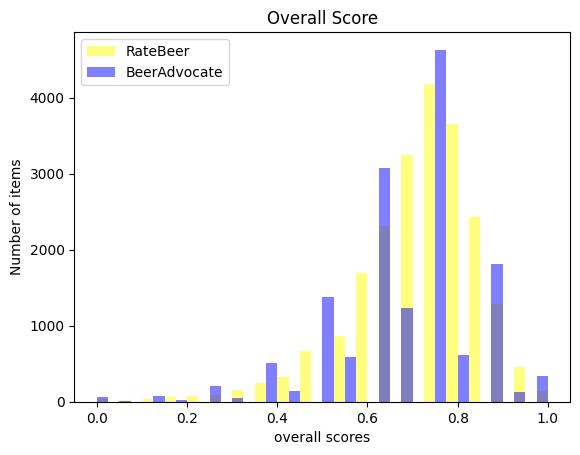

In [45]:
# plot the histgram of the overall score from two websites respectively
plt.hist(ratings_rb['overall'], bins=40, alpha = 0.5, label = 'RateBeer', color='yellow')
plt.hist(ratings_ba['overall'], bins=40, alpha = 0.5, label = 'BeerAdvocate', color='blue')

plt.xlabel('overall scores')
plt.ylabel('Number of items')
plt.title('Overall Score')
plt.legend()

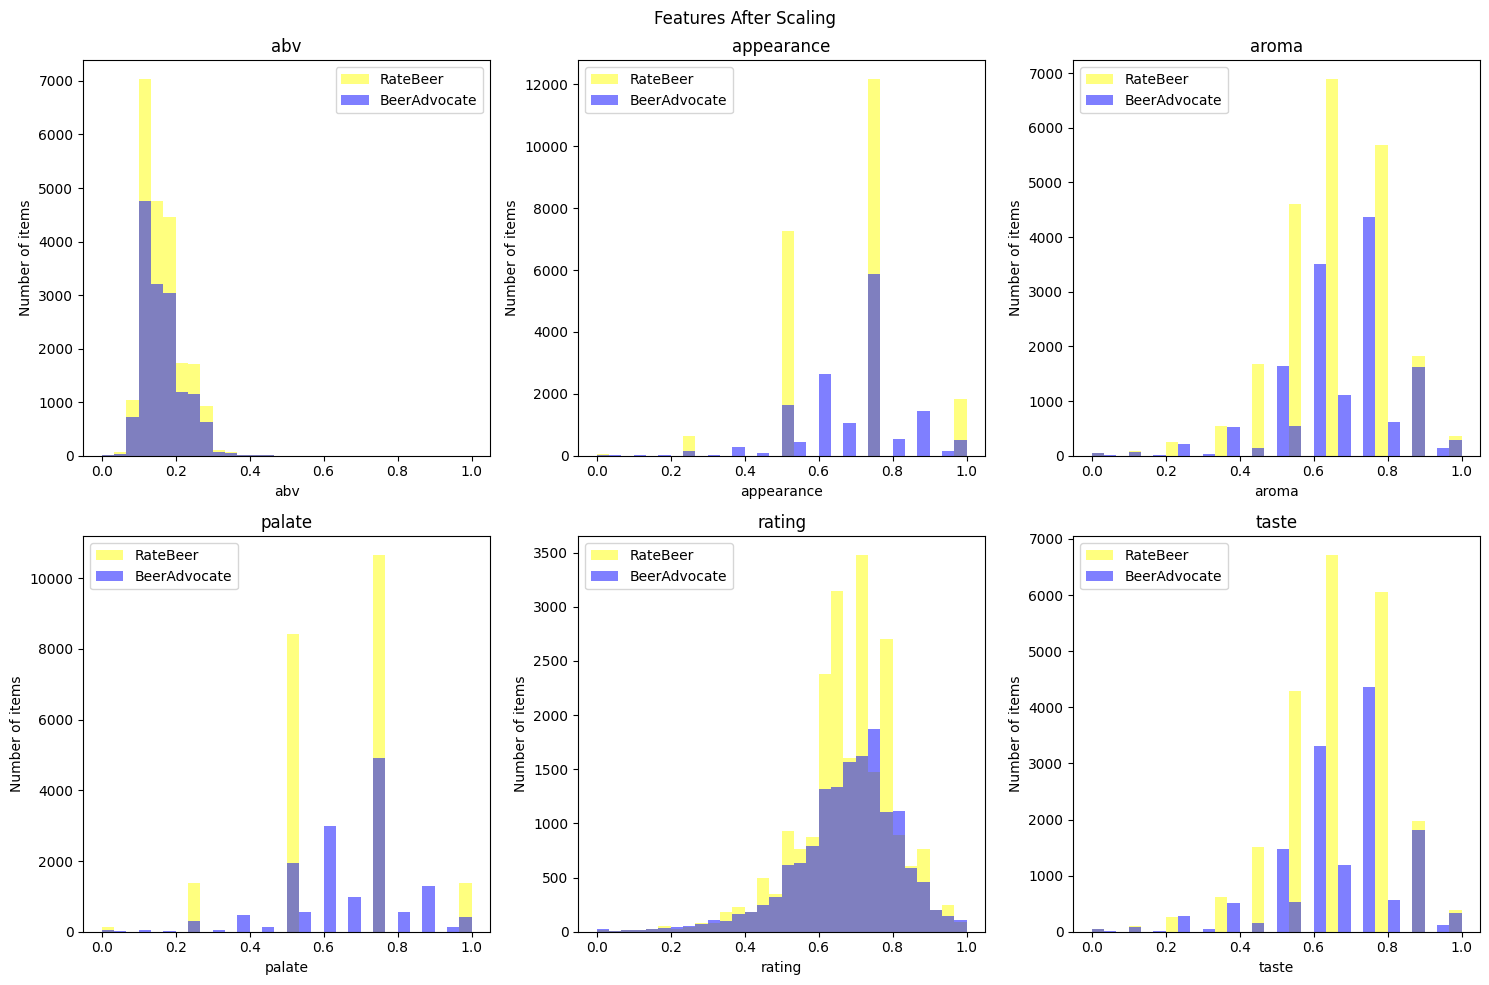

In [46]:
# plot the histgram of other features from the two websites
rows = 2
cols = 3
fig, axs = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))

i = 0
for feature in convert_features:
    if feature != 'overall':
        ax = axs[i//cols][i%cols]
        ax.hist(ratings_rb[feature], bins=30, alpha = 0.5, label = 'RateBeer', color='yellow')
        ax.hist(ratings_ba[feature], bins=30, alpha = 0.5, label = 'BeerAdvocate', color='blue')
        ax.set_xlabel(feature)
        ax.set_ylabel('Number of items')
        ax.set_title(feature)
        ax.legend()
        i += 1
        
plt.suptitle('Features After Scaling')
fig.tight_layout()
plt.show()

We found the distribution between 'appearance' and 'palate'; 'taste' and 'aroma' are really similar. So then we'll try to explore the connection across the features.

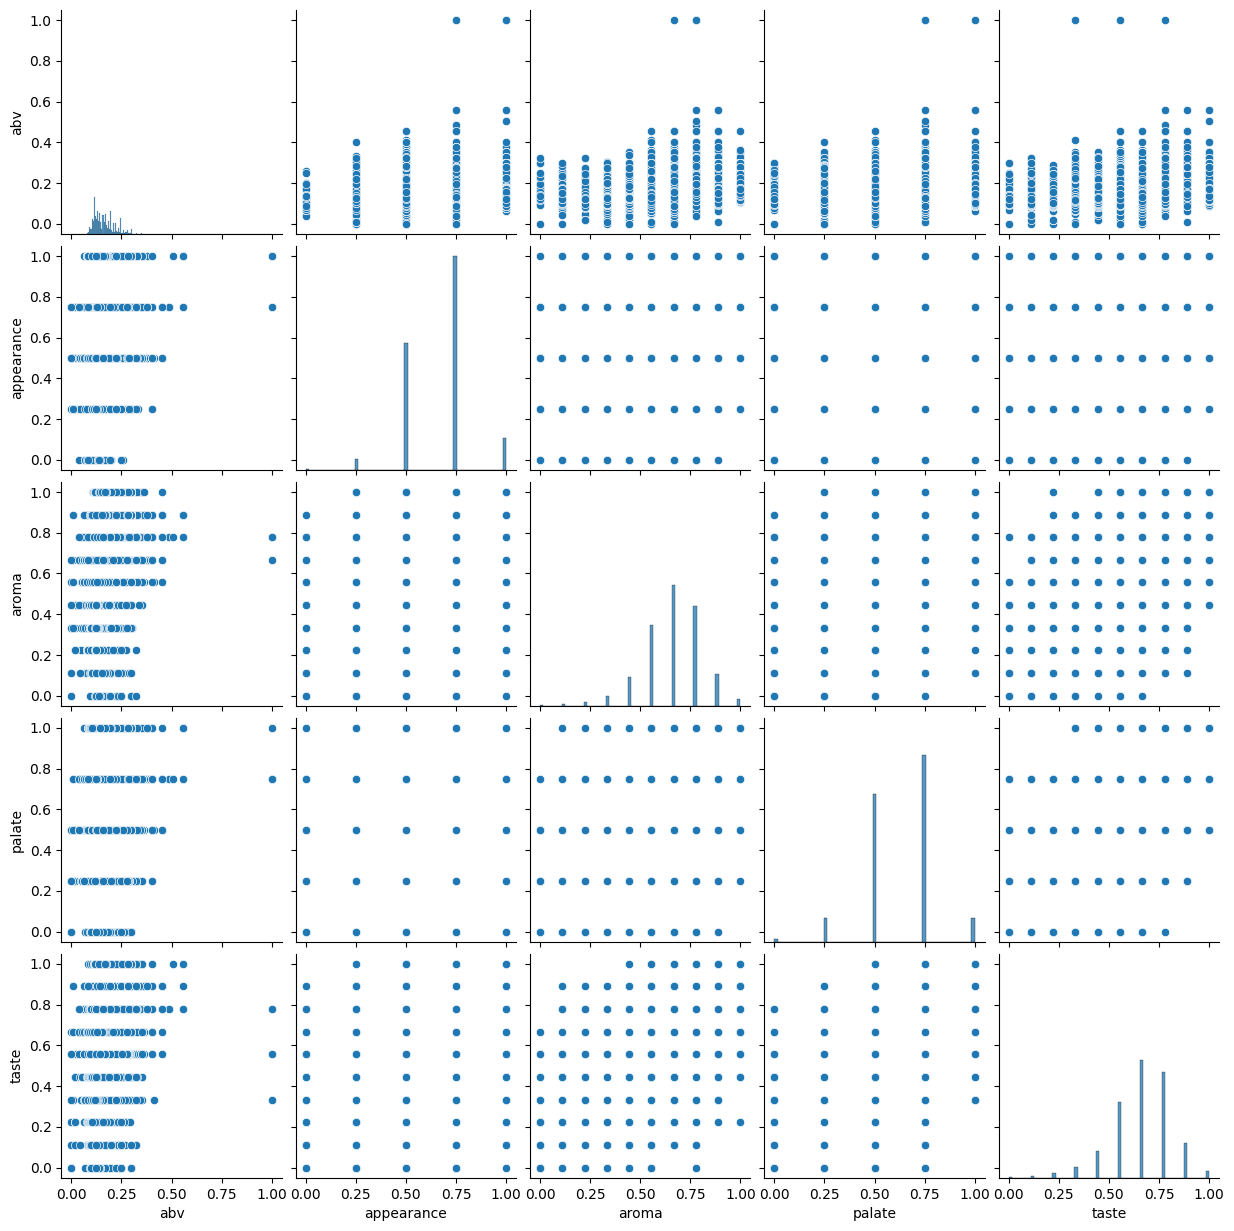

In [47]:
detailed_features = ['abv', 'appearance', 'aroma', 'palate', 'taste']
sns.pairplot(ratings_rb[detailed_features])
plt.show()

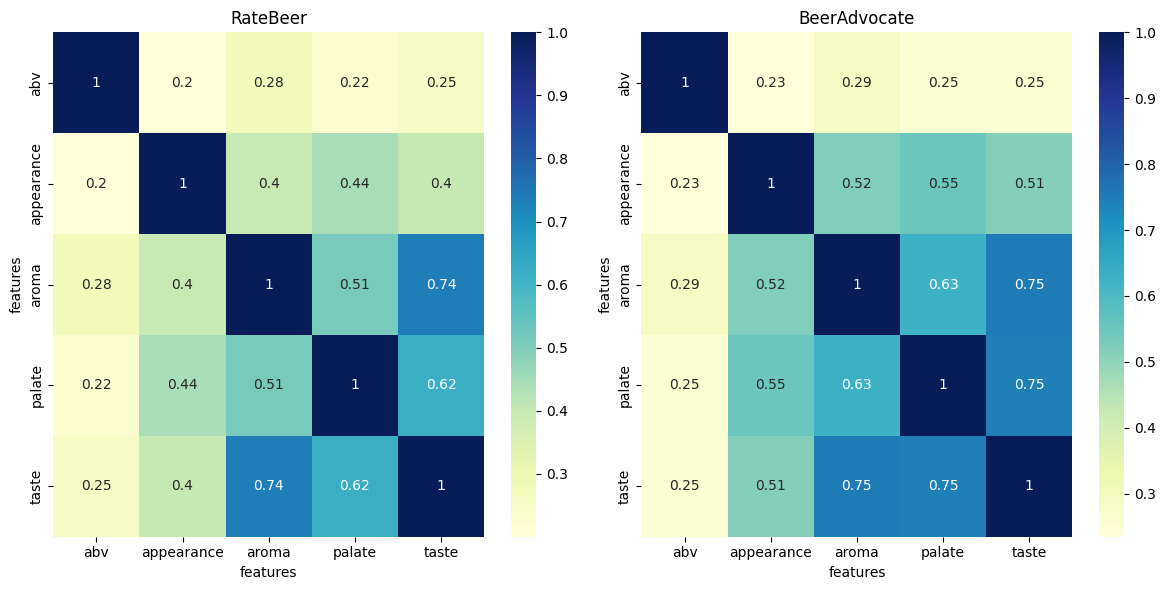

In [48]:
# heat map for different features:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
sns.heatmap(ratings_rb[detailed_features].corr(), ax = axs[0], annot=True, cmap='YlGnBu', cbar=True)
sns.heatmap(ratings_ba[detailed_features].corr(), ax = axs[1], annot=True, cmap='YlGnBu', cbar=True)
axs[0].set_title('RateBeer')
axs[0].set_xlabel('features')
axs[0].set_ylabel('features')

axs[1].set_title('BeerAdvocate')
axs[1].set_xlabel('features')
axs[1].set_ylabel('features')
fig.tight_layout()
plt.show()


There are some strong linear connections between features. These can be discussed in details in our further work.

In [65]:
# try regression model on features and overall ratings
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split

model = RidgeCV(alphas=[0.01, 0.05, 0.1])
X_train, X_test, y_train, y_test = train_test_split(
    ratings_ba[detailed_features], ratings_ba["overall"], test_size=0.2, random_state=42
)

In [68]:
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.7657079232007463

In [75]:
# check the contribution of each coefficient
sorted_coef_pairs = sorted(
    zip(model.coef_, detailed_features), key=lambda x: abs(x[0]), reverse=True
)
sorted_coefs = [pair[0] for pair in sorted_coef_pairs]
sorted_features = [pair[1] for pair in sorted_coef_pairs]

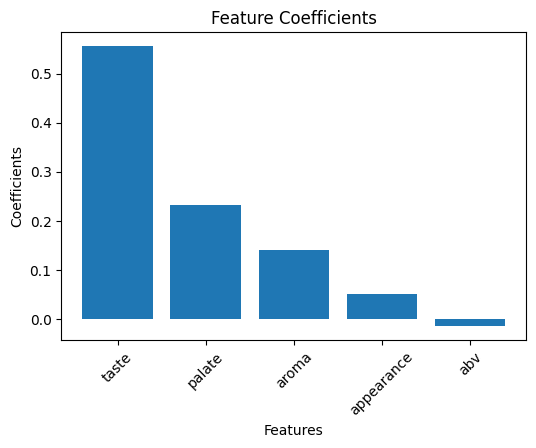

In [80]:
plt.figure(figsize=(6, 4))  # You can adjust the figure size as needed
plt.bar(sorted_features, sorted_coefs)

# Adding labels and title
plt.xlabel('Features')
plt.ylabel('Coefficients')
plt.title('Feature Coefficients')
plt.xticks(rotation=45)  # Rotates feature names for better readability

plt.show()

## Features in 'Users' dataset

In [15]:
users_loc_ba = users_ba.groupby('location').size()
users_loc_rb = users_rb.groupby('location').size()

In [16]:
False in users_loc_ba == users_loc_rb

False

Notice that 'location' counts states for US users and countries only for other users, so break the data down into US users and non-US users. Since the dataset is matched, we only need to discuss the loaction distribution of one website.

In [17]:
# splite the us and non-us users
users_loc_ba_US = users_loc_ba[users_loc_ba.index.str.contains('United States')]
users_loc_ba_nonUS = users_loc_ba[~users_loc_ba.index.str.contains('United States')]

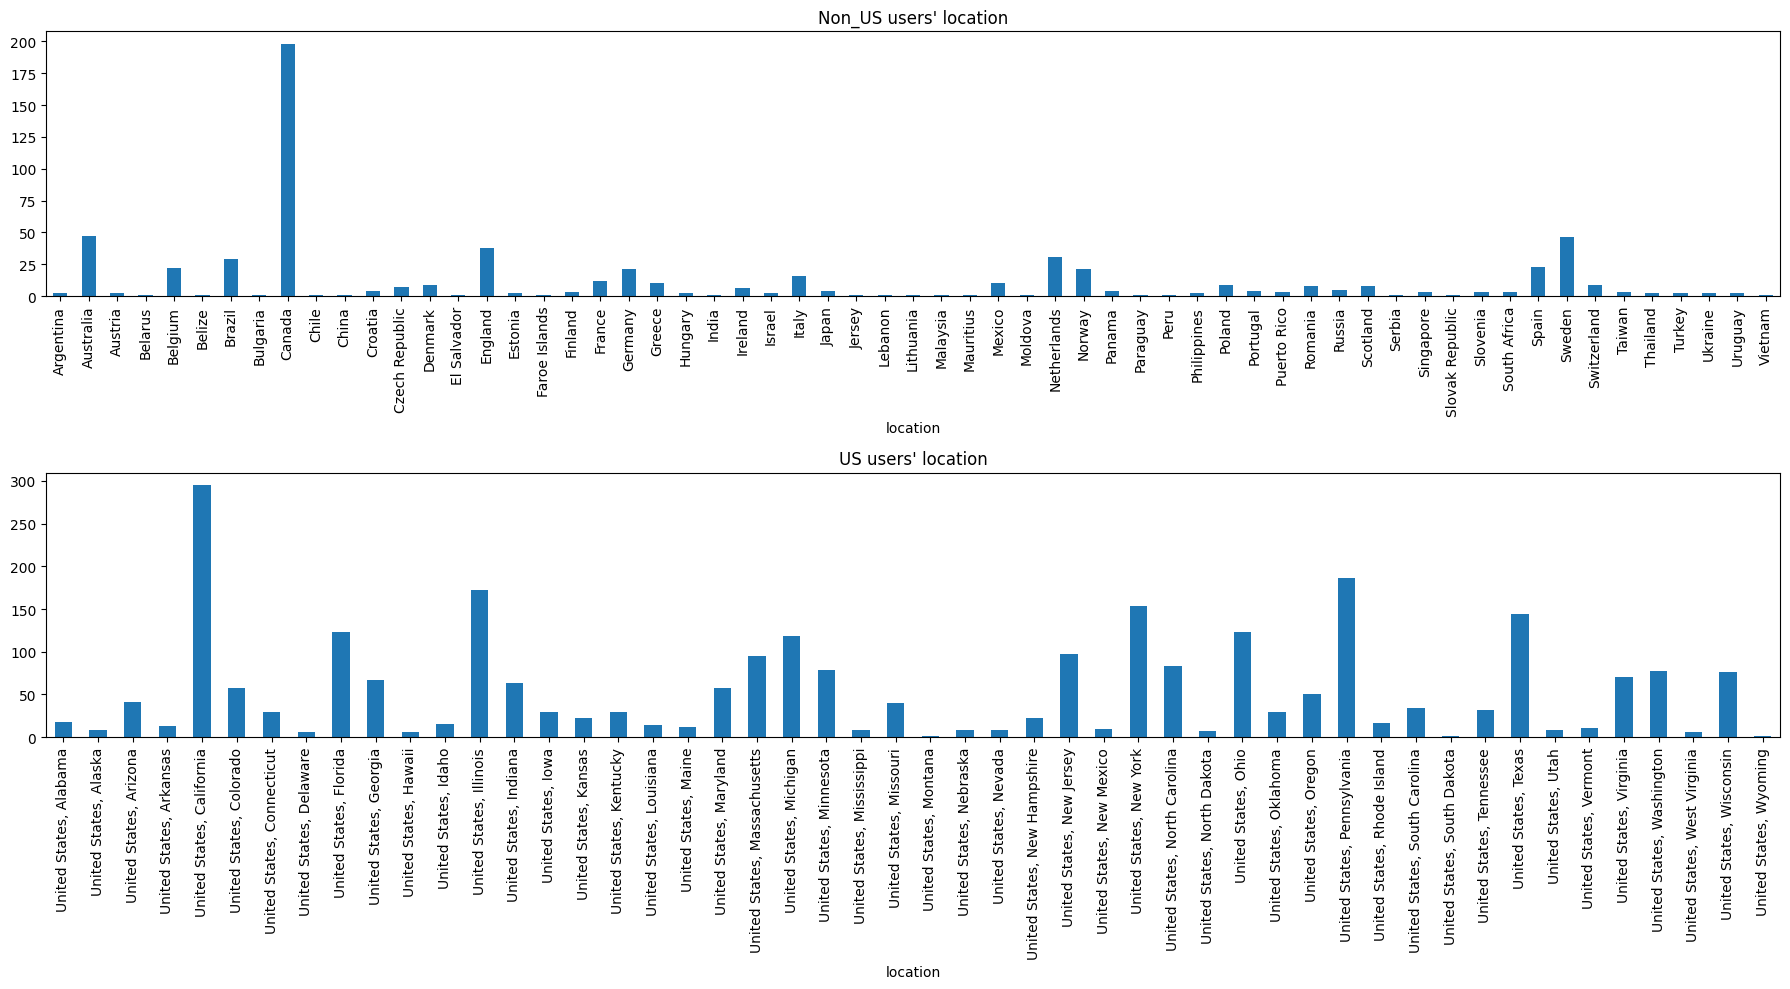

In [18]:
fig, axs = plt.subplots(2, 1, figsize = (18, 10))
users_loc_ba_nonUS.plot(kind = 'bar', ax = axs[0])
users_loc_ba_US.plot(kind = 'bar', ax = axs[1])

axs[0].set_title("Non_US users' location")
axs[1].set_title("US users' location")

fig.tight_layout()
plt.show()

There are far more users in the United States than in other countries, which will be taken into account in our subsequent work.

## Features in 'Breweries' dataset

In [19]:
breweries_loc_rb = breweries_rb.groupby('location').size()
breweries_loc_ba = breweries_ba.groupby('location').size()

In [20]:
False in breweries_loc_rb == breweries_loc_ba

False

In [21]:
# splite the us and non_us locations
breweries_loc_ba_US = breweries_loc_ba[
    breweries_loc_ba.index.str.contains("United States", "U.S.")
    | breweries_loc_ba.index.str.contains("U.S.")
]
breweries_loc_ba_nonUS = breweries_loc_ba[
    ~(
        breweries_loc_ba.index.str.contains("United States", "U.S.")
        | breweries_loc_ba.index.str.contains("U.S.")
    )
]

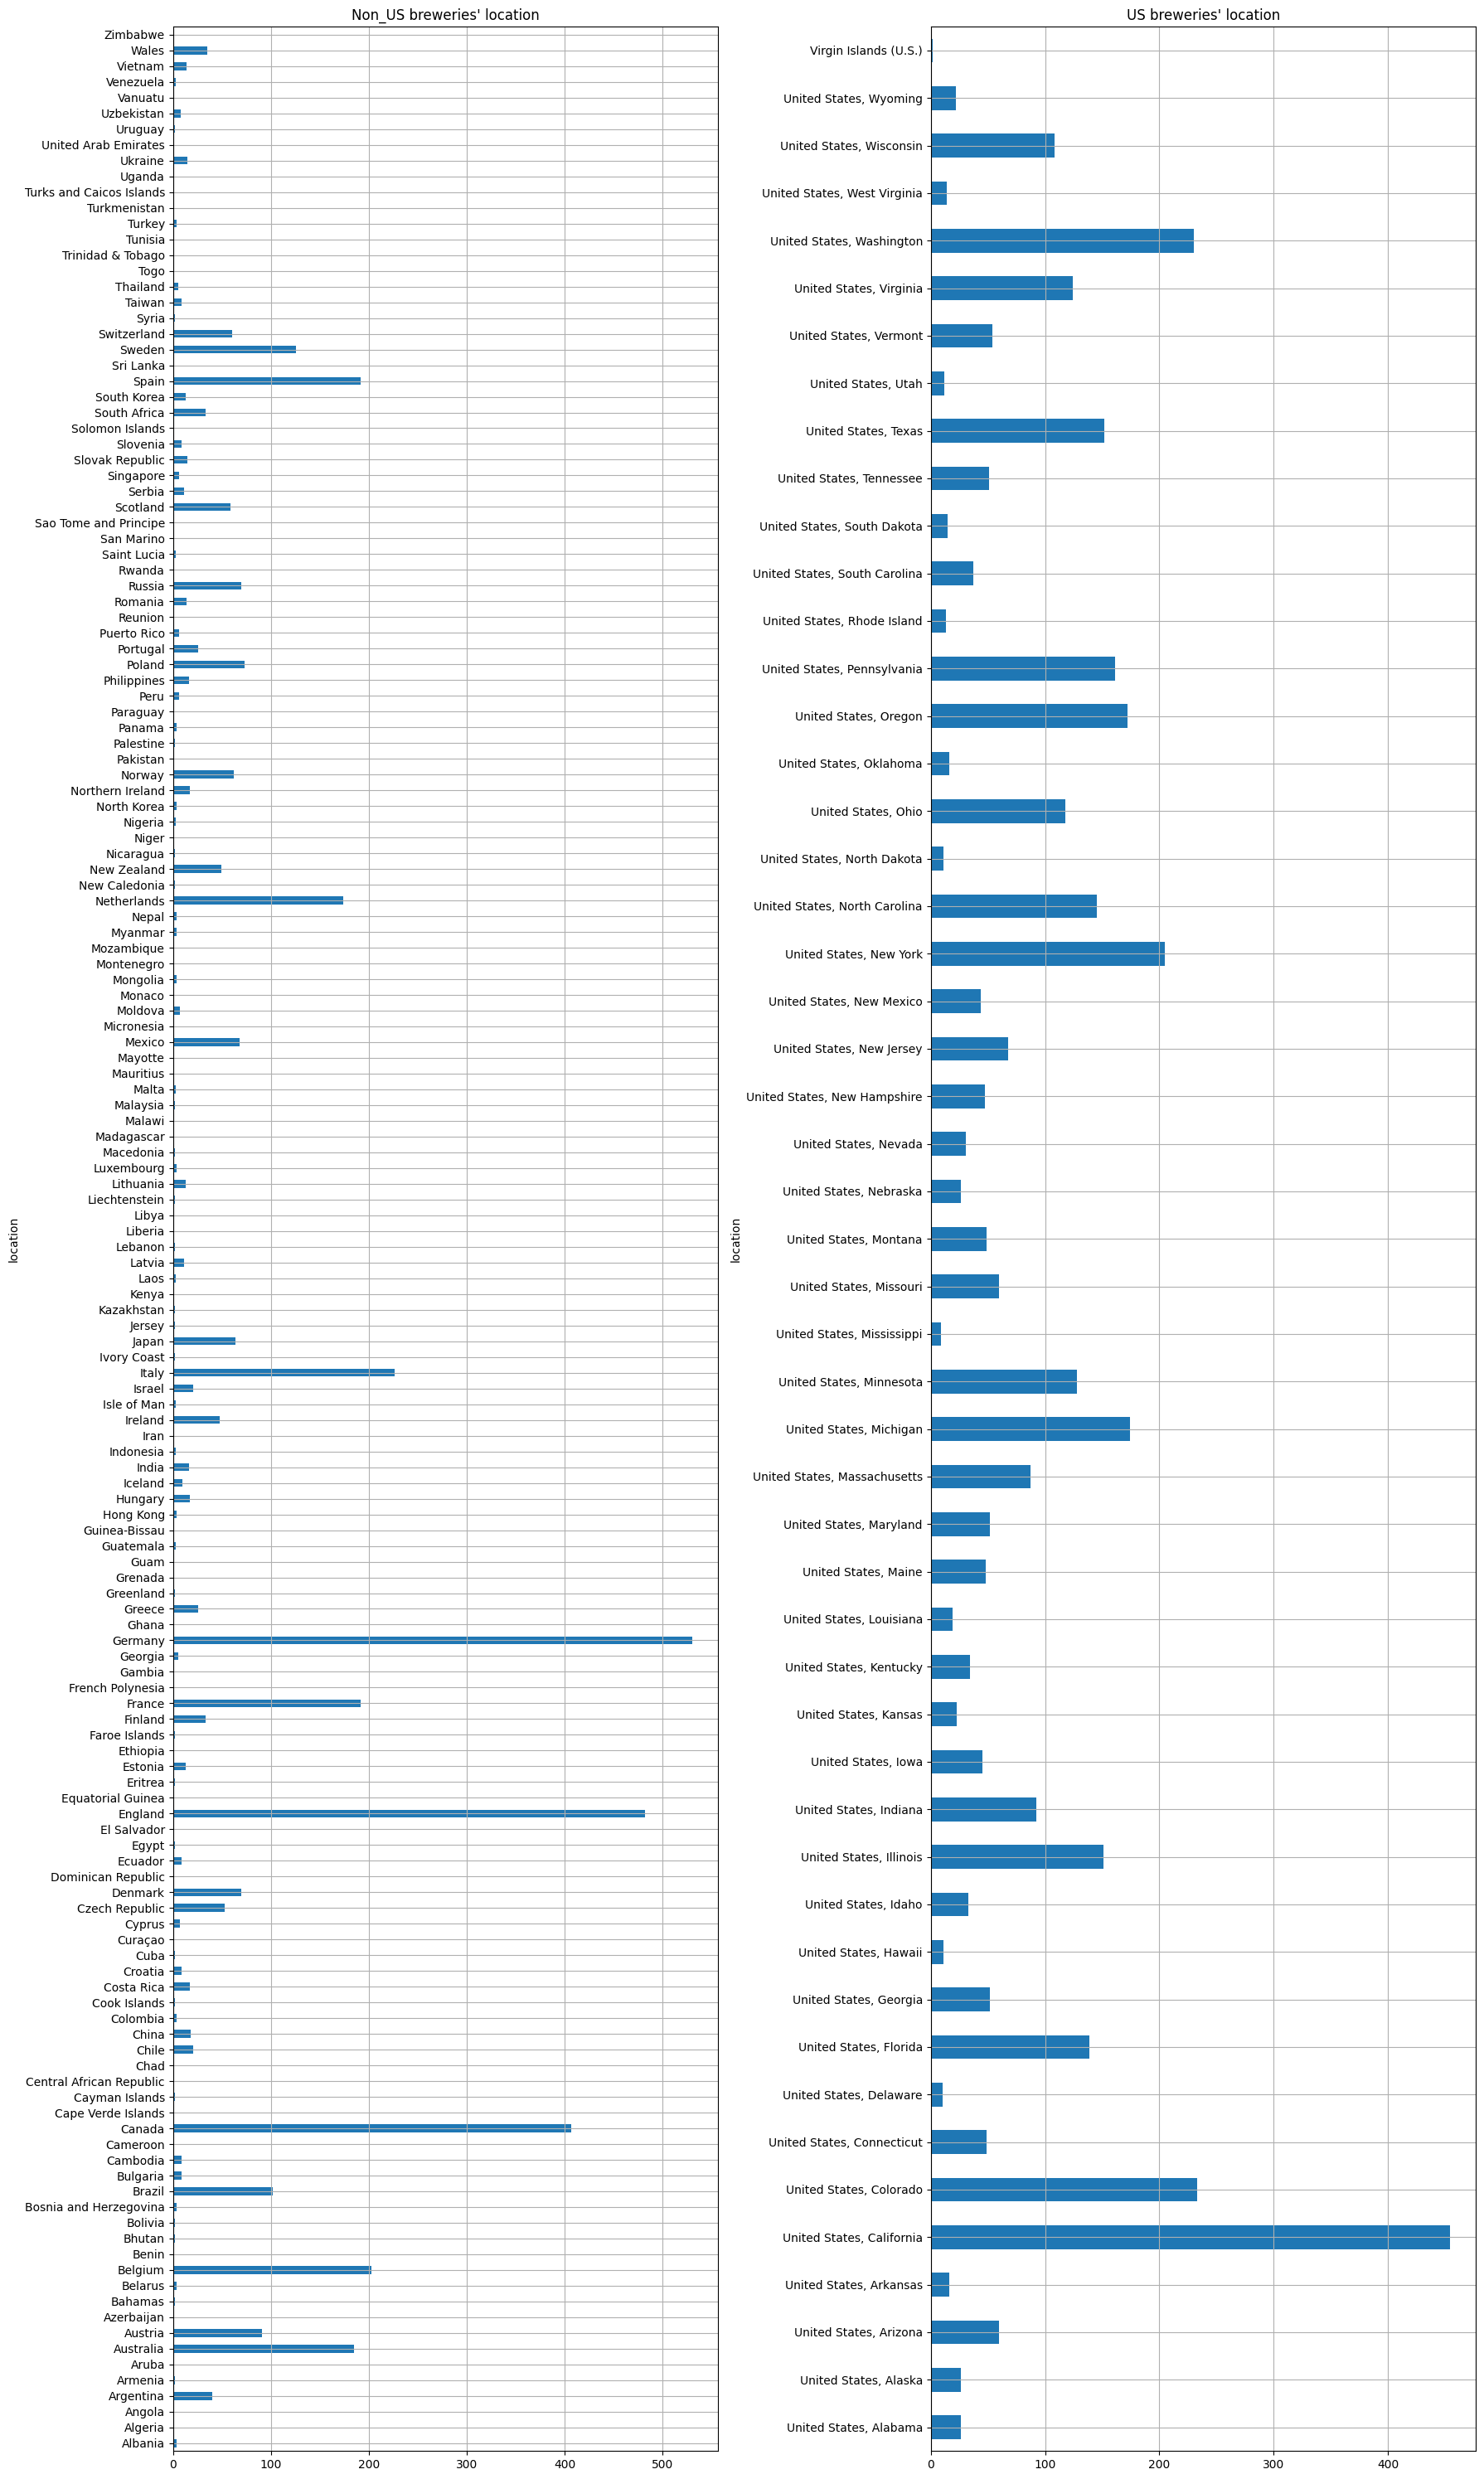

In [22]:
fig, axs = plt.subplots(1, 2, figsize = (18, 30))
breweries_loc_ba_nonUS.plot(kind = 'barh', ax = axs[0], grid=True)
breweries_loc_ba_US.plot(kind = 'barh', ax = axs[1], grid=True)

axs[0].set_title("Non_US breweries' location")
axs[1].set_title("US breweries' location")

fig.tight_layout()
plt.show()

## Mathematical Details
### 1. K-means
K-means can be considered an optimization problem
$$
\begin{align*}
C^*=\mathrm{arg} \min\limits_{C} W(C)=
\mathrm{arg} \min\limits_{C}\sum_{l=1}^{k}\sum_{C(i)=l} d(x_i, m_j)
\end{align*}
$$
This is to solve the best clustering $C^*$ such that the sum of the distance between the data point and the centroids/clustroid of its cluster is minimized under the selected metric. $d(x_i, m_j)$ is the distance between $x_i$ and the centroid/centroid $m_j$ of cluster $C_j$.

Suppose we use the squared Euclidean distance $d(x_i, m_j) = ||x_i-m_l||^2$ . After initializing the cluster centroids $m_1, m_2, \cdots, m_k$, the algorithm is solved by two steps:

1. **Find the nearest cluster for each data point and assign them to the corresponding cluster**. 

   Find $C^*$ s.t.  $C^* = \mathrm{arg} \min\limits_{C}\sum\limits_{l=1}^{k}\sum\limits_{C(i)=l} ||x_i-m_l||^2$ for the given $m_1,m_2,... m_l$.

2. **Update the cluster centroid of each cluster.** 

   For current $C$, recompute $m_l=\frac{1}{|C_l|}\sum\limits_{C(i)=l}x_i$ for $l = 1, \cdots k$.	

Alternate these two steps until the stop criterion.